In [38]:
import numpy as np
# from Scripts.DataManager.DabasePreparations.AmazonReviewSentiGraph import AmazonReviewSentiGraph
# from Scripts.Models.ModelsManager.SimpleGraphClassifierModelManager import SimpleGraphClassifierModelManager
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os

In [39]:
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
# os.environ['TORCH_USE_CUDA_DSA']
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 128

In [40]:
from typing import List, Set, Tuple, Any
from abc import ABC, abstractmethod

from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
# from torch_geometric.data.lightning.datamodule import LightningDataModule
from lightning.pytorch import LightningDataModule
from torch_geometric.utils import augmentation
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.utils import subgraph, train_test_split_edges
from torch_geometric.data import Data

from Scripts.Configs.ConfigClass import Config
from Scripts.Utils.GraphCollection.GraphCollection import GraphCollection

class GraphDataModule(LightningDataModule):

    def __init__(self, config: Config, device, has_val: bool, has_test: bool, test_size=0.2, val_size=0.15, *args, **kwargs):
        super(GraphDataModule, self).__init__() #has_val, has_test, **kwargs)
        self.config = config
        self.test_size = test_size
        self.val_size = val_size
        self.device = device

    @abstractmethod
    def prepare_data(self):
        pass

    @abstractmethod
    def setup(self, stage: str):
        pass

    @abstractmethod
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        pass

    @abstractmethod
    def test_dataloader(self) -> EVAL_DATALOADERS:
        pass

    @abstractmethod
    def val_dataloader(self) -> EVAL_DATALOADERS:
        pass

    @abstractmethod
    def teardown(self, stage: str) -> None:
        pass
    
    @abstractmethod
    def zero_rule_baseline():
        pass

    # def predict_dataloader(self) -> EVAL_DATALOADERS:
    # def transfer_batch_to_device(self, batch: Any, device: torch.device, dataloader_idx: int) -> Any:
    # def on_before_batch_transfer(self, batch: Any, dataloader_idx: int) -> Any:
    # def on_after_batch_transfer(self, batch: Any, dataloader_idx: int) -> Any:

In [41]:
from os import path
from typing import Dict

import pandas as pd
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.CoOccurrenceGraphConstructor import CoOccurrenceGraphConstructor
from Scripts.DataManager.GraphConstructor.GraphConstructor import GraphConstructor, TextGraphType
# from Scripts.DataManager.GraphLoader.GraphLoader import GraphLoader
from torch.utils.data.dataset import random_split
import torch
from Scripts.DataManager.Datasets.GraphConstructorDataset import GraphConstructorDataset

class AmazonReviewGraphDataModule(GraphDataModule):

    def __init__(self, config: Config, has_val: bool, has_test: bool, test_size=0.2, val_size=0.2, num_workers=2,
                 drop_last=True, train_data_path='', test_data_path='', graphs_path='', batch_size = 32,
                 device='cpu', shuffle = False, num_data_load=-1,
                 graph_type: TextGraphType = TextGraphType.CO_OCCURRENCE, *args, **kwargs):
        kwargs['num_workers'] = num_workers
        kwargs['batch_size'] = batch_size
        kwargs['num_workers'] = num_workers
        kwargs['shuffle'] = shuffle
        super(AmazonReviewGraphDataModule, self)\
            .__init__(config, device, has_val, has_test, test_size, val_size, *args, **kwargs)

        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.drop_last = drop_last
        self.graph_type = graph_type
        self.train_data_path = 'data/Amazon-Review/train_sm.csv' if train_data_path == '' else train_data_path
        self.test_data_path = 'data/Amazon-Review/test_sm.csv' if test_data_path == '' else test_data_path
        self.train_df: pd.DataFrame = pd.DataFrame()
        self.test_df: pd.DataFrame = pd.DataFrame()
        self.labels = None
        self.dataset = None
        self.shuffle = shuffle
        self.num_node_features = 0
        self.num_classes = 0
        self.df: pd.DataFrame = pd.DataFrame()
        self.__train_dataset, self.__val_dataset, self.__test_dataset = None, None, None
        self.train_df = pd.read_csv(path.join(self.config.root, self.train_data_path))
        self.test_df = pd.read_csv(path.join(self.config.root, self.test_data_path))
        self.train_df.columns = ['Polarity', 'Title', 'Review']
        self.test_df.columns = ['Polarity', 'Title', 'Review']
        self.train_df = self.train_df[['Polarity', 'Review']]
        self.test_df = self.test_df[['Polarity', 'Review']]
        self.df = pd.concat([self.train_df, self.test_df])
        self.num_data_load = num_data_load if num_data_load>0 else self.df.shape[0]
        self.num_data_load = num_data_load if self.num_data_load < self.df.shape[0] else self.df.shape[0] 
        self.df = self.df.iloc[:self.num_data_load]
        self.df.index = np.arange(0, self.num_data_load)
        self.graph_constructors = self.__set_graph_constructors(self.graph_type)
        graph_constructor = self.graph_constructors[TextGraphType.CO_OCCURRENCE]
        graph_constructor.setup()
        print(f'self.num_data_load: {self.num_data_load}')
        labels = self.df['Polarity'][:self.num_data_load]
        labels = labels.apply(lambda p: 0 if p == 1 else 1).to_numpy()
        labels = torch.from_numpy(labels)
        self.labels = labels.to(torch.float32).view(-1, 1).to(self.device)
        graph_constructor = self.graph_constructors[TextGraphType.CO_OCCURRENCE]
        
        print(f'self.labels.shape: {self.labels.shape}')
        self.dataset = GraphConstructorDataset(graph_constructor, self.labels)
        sample_graph = graph_constructor.get_first()
        self.num_node_features = sample_graph.num_features
        self.num_classes = len(torch.unique(self.labels))
        self.__train_dataset, self.__val_dataset, self.__test_dataset =\
            random_split(self.dataset, [1-self.val_size-self.test_size, self.val_size, self.test_size])
        self.__train_dataloader =  DataLoader(self.__train_dataset, batch_size=self.batch_size, drop_last=self.drop_last, shuffle=self.shuffle, num_workers=0, persistent_workers=False)
        self.__test_dataloader =  DataLoader(self.__test_dataset, batch_size=self.batch_size, num_workers=0, persistent_workers=False)
        self.__val_dataloader =  DataLoader(self.__val_dataset, batch_size=self.batch_size, num_workers=0, persistent_workers=False)
        
    def prepare_data(self):
        pass
        
    def setup(self, stage: str):
        pass

    def teardown(self, stage: str) -> None:
        pass

    def train_dataloader(self):
        return self.__train_dataloader

    def test_dataloader(self):
        return self.__test_dataloader

    def val_dataloader(self):
        return self.__val_dataloader 

    def __set_graph_constructors(self, graph_type: TextGraphType):
        graph_constructors: Dict[TextGraphType, GraphConstructor] = {}
        if TextGraphType.CO_OCCURRENCE in graph_type:
            graph_constructors[TextGraphType.CO_OCCURRENCE] = self.__get_co_occurrence_graph()
        if TextGraphType.DEPENDENCY in graph_type:
            pass
        if TextGraphType.SEQUENTIAL in graph_type:
            pass
        if TextGraphType.TAGS in graph_type:
            pass
        return graph_constructors

    def __get_co_occurrence_graph(self):
        print(f'self.num_data_load: {self.num_data_load}')
        return CoOccurrenceGraphConstructor(self.df['Review'][:self.num_data_load], 'data/GraphData/AmazonReview', self.config, lazy_construction=False, load_preprocessed_data=True, naming_prepend='graph', num_data_load=self.num_data_load, device=self.device)
    
    def zero_rule_baseline(self):
        return f'zero_rule baseline: {(len(self.labels[self.labels>0.5])* 100.0 / len(self.labels))  : .2f}%'

In [42]:
data_manager = AmazonReviewGraphDataModule(config, True, True, num_workers=2, shuffle=True, num_data_load = 5000, device='cpu', batch_size=batch_size)

self.num_data_load: 5000
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AmazonReview\graph_var.txt
 0 graph loaded
 100 graph loaded
 200 graph loaded
 300 graph loaded
 400 graph loaded
 500 graph loaded
 600 graph loaded
 700 graph loaded
 800 graph loaded
 900 graph loaded
 1000 graph loaded
 1100 graph loaded
 1200 graph loaded
 1300 graph loaded
 1400 graph loaded
 1500 graph loaded
 1600 graph loaded
 1700 graph loaded
 1800 graph loaded
 1900 graph loaded
 2000 graph loaded
 2100 graph loaded
 2200 graph loaded
 2300 graph loaded
 2400 graph loaded
 2500 graph loaded
 2600 graph loaded
 2700 graph loaded
 2800 graph loaded
 2900 graph loaded
 3000 graph loaded
 3100 graph loaded
 3200 graph loaded
 3300 graph loaded
 3400 graph loaded
 3500 graph loaded
 3600 graph loaded
 3700 graph loaded
 3800 graph loaded
 3900 graph loaded
 4000 graph loaded
 4100 graph loaded
 4200 graph loaded
 4300 graph loaded
 4400 graph loaded
 4500 graph loaded
 4600 graph loaded

In [44]:
data_manager.zero_rule_baseline()

'zero_rule baseline:  46.16%'

In [45]:
t_dataloader = data_manager.train_dataloader()

In [46]:
X,y = next(iter(t_dataloader))
X = X.to(device)
y = y.to(device)

In [47]:
from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1
# from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1
from Scripts.Models.LightningModels.LightningModels import BinaryLightningModel
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import torch
import lightning as L
from lightning.pytorch.tuner import Tuner
import time

In [136]:
import torch
import torch_geometric
from torch.nn import Linear
from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv, DenseGCNConv, dense_diff_pool, BatchNorm, global_mean_pool, global_add_pool, global_max_pool, MemPooling, SAGEConv, to_hetero
from torch_geometric.nn import Sequential as GSequential
from torch_geometric.utils import to_dense_adj
from torch import nn, Tensor
import torch.nn.functional as F


class EmbeddingModel(nn.Module):
    def __init__(self, in_feature, out_feature, hidden_feature=64, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = SAGEConv(in_feature, hidden_feature)
        self.conv2 = SAGEConv(hidden_feature, hidden_feature)
        self.conv3 = SAGEConv(hidden_feature, out_feature)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

class DepTagModel(nn.Module):
    r"""
    This class is for graph level classification or graph level regression
    """

    def __init__(self, input_feature: int, out_features: int, base_hidden_feature: int=256, dropout=0.1, *args, **kwargs):
        super(GcnGatModel1, self).__init__(*args, **kwargs)
        self.input_features = input_feature
        self.num_out_features = out_features
        self.bsh: int = base_hidden_feature
        bsh2: int = int(self.bsh/2)
        bsh4: int = int(self.bsh/4)
        bsh8: int = int(self.bsh/8)
        
        self.encoder = GSequential('x, edge_index, edge_weights', [
            (GCNConv(input_feature, self.bsh), 'x, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            
            (GCNConv(self.bsh, bsh2), 'x1, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            
            (GCNConv(bsh2, bsh4), 'x2, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (nn.Dropout(dropout), 'x3->x3'),
            (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (nn.Dropout(dropout), 'x3->x3'),
            (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (nn.Dropout(dropout), 'x3->x3'),
            
            (GCNConv(bsh4, bsh8), 'x3, edge_index, edge_weights -> x4'),
            (BatchNorm(bsh8), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            (nn.Dropout(dropout), 'x4->x4'),
            (GCNConv(bsh8, bsh8), 'x4, edge_index, edge_weights -> x4'),
            (BatchNorm(bsh8), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            (nn.Dropout(dropout), 'x4->x4'),
            (GCNConv(bsh8, bsh8), 'x4, edge_index, edge_weights -> x4'),
            (BatchNorm(bsh8), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            (lambda x1, x2, x3, x4: (x1, x2, x3, x4), 'x1, x2, x3, x4 -> x1, x2, x3, x4')
        ])
        
        self.attention = GSequential('x3, x4, edge_index, edge_weights', [
            (GATv2Conv(bsh8, bsh8, 2, dropout=dropout), 'x4, edge_index ->x4'),
            (BatchNorm(bsh4), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            
            (GCN2Conv(bsh4, 0.5, 0.1, 2), 'x4, x3, edge_index, edge_weights->x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            
            (GATv2Conv(bsh4, bsh4, 2, dropout=dropout), 'x3, edge_index ->x3'),
            (BatchNorm(bsh2), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (lambda x3, x4: (x3, x4), 'x3, x4 -> x3, x4')
        ])
        
        self.decoder = GSequential('x1, x2, x3, edge_index, edge_weights', [
            
            (GCN2Conv(bsh2, 0.5, 0.1, 2), 'x3, x2, edge_index, edge_weights->x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, self.bsh), 'x2, edge_index->x2'),
            (BatchNorm(self.bsh), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            
            (GCN2Conv(self.bsh, 0.5, 0.1, 2), 'x2, x1, edge_index, edge_weights->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (lambda x1, x2, x3: (x1, x2, x3), 'x1, x2, x3 -> x, x2, x3')
        ])

        # self.pool_batch_norm = BatchNorm(self.bsh)
        self.mem_pool = MemPooling(self.bsh, 128, 4, 2)
        self.output_layer = Linear(self.bsh, self.num_out_features)
        
        

    def forward(self, x):
        x1, x2, x3, x_enc = self.encoder(x.x, x.edge_index, x.edge_attr)
        x_att, x4 = self.attention(x3, x_enc, x.edge_index, x.edge_attr)
        x_dec, x2, x3 = self.decoder(x1, x2, x_att, x.edge_index, x.edge_attr)
        # g_pooled = global_mean_pool(x_dec, x.batch)
        # g_pooled = self.pool_batch_norm(g_pooled)
        
        x_pooled, S = self.mem_pool(x_dec, x.batch)
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        return self.output_layer(x_pooled)

In [137]:
torch_model = GcnGatModel1(300, 1, 256, 0.4).to(device)

In [131]:
sample = torch_model(X)

torch.Size([128, 256])


In [132]:
torch_model = GcnGatModel1(300, 1, 256, 0.4).to(device)
lightning_model = BinaryLightningModel(torch_model,
                                       torch.optim.Adam(torch_model.parameters(), lr=0.0001, weight_decay=0.00055),
                                       torch.nn.BCEWithLogitsLoss(),
                                       learning_rate=0.0001,
                                       batch_size=batch_size,
                                       ).to(device)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [133]:
trainer = L.Trainer(
            max_epochs=1000,
            accelerator='gpu',
            num_sanity_val_steps=0,
            log_every_n_steps=2000,
            logger=CSVLogger(save_dir='logs/', name='DepTag2')
            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [134]:
tuner = Tuner(trainer)
lr_result = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=1e-3, max_lr=1e-1)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:43: attribute 'model' removed from hparams because it cannot be pickled
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb
train_fn: <bound method Trainer._fit_impl of <lightning.pytorch.trainer.trainer.Trainer object at 0x000001A53CDFA830>>


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=2000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([104, 256])


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([104, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size([128, 256])
torch.Size(

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0017378008287493754
Restoring states from the checkpoint path at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_c851232a-8d8a-422c-b8bd-d0777d270665.ckpt
Restored all states from the checkpoint at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_c851232a-8d8a-422c-b8bd-d0777d270665.ckpt


torch.Size([128, 256])


In [139]:
lr_result.suggestion()

0.0017378008287493754

C:\Users\fardin\AppData\Local\Temp\ipykernel_10588\2893718476.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


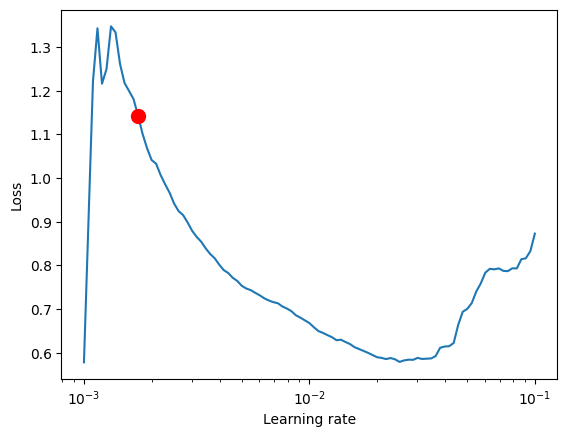

In [135]:
fig = lr_result.plot(suggest=True)
fig.show()

In [142]:
torch_model = GcnGatModel1(300, 1, 256, 0.4).to(device)
lightning_model = BinaryLightningModel(torch_model,
                                       torch.optim.Adam(torch_model.parameters(), lr=0.001737, weight_decay=0.00055),
                                       torch.nn.BCEWithLogitsLoss(),
                                       learning_rate=0.001737,
                                       batch_size=batch_size,
                                       ).to(device)

In [143]:
trainer = L.Trainer(
            max_epochs=1000,
            accelerator='gpu',
            num_sanity_val_steps=0,
            log_every_n_steps=2000,
            logger=CSVLogger(save_dir='logs/', name='DepTag2')
            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [144]:
trainer.fit(model=lightning_model, datamodule=data_manager)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:43: attribute 'model' removed from hparams because it cannot be pickled
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type              | Params
------------------------------------------------
0 | model     | GcnGatModel1      | 629 K 
1 | loss_func | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
4 | test_acc  | BinaryAccuracy    | 0     
------------------------------------------------
629 K     Trainable params
0         Non-trainable params
629 K     Total params
2.516     Total estimated model params size (MB)


bbbb
train_fn: <bound method Trainer._fit_impl of <lightning.pytorch.trainer.trainer.Trainer object at 0x000001A5442E5BD0>>


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=2000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:61: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# import torch
# from torch.nn import Linear
# from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv, DenseGCNConv, dense_diff_pool, BatchNorm
# from torch_geometric.nn import Sequential as GSequential
# from torch_geometric.utils import to_dense_adj
# from torch import nn

# class DepTagModel1(nn.Module):
#     r"""
#     This class is for graph level classification or graph level regression
#     """

#     def __init__(self, input_feature: int, out_features: int, base_hidden_feature: int=256, dropout=0.1, *args, **kwargs):
#         super(DepTagModel1, self).__init__(*args, **kwargs)
#         self.input_features = input_feature
#         self.num_out_features = out_features
#         self.bsh: int = base_hidden_feature
#         bsh2: int = int(self.bsh/2)
#         bsh4: int = int(self.bsh/4)
#         bsh8: int = int(self.bsh/8)
        
#         self.composition_layer = GSequential('x_text, edge_index_text, edge_weights_text, x_tag, edge_index_tag, edge_weights_tag, x_dep, edge_index_dep, edge_weights_dep', [
#             (GCNConv(input_feature, self.bsh), 'x_text, edge_index_text, edge_weights_text ->x1'),
#             (BatchNorm(self.bsh), 'x1->x1'),
#             (nn.ReLU(), 'x1->x1'),
#             (GCNConv(input_feature, self.bsh), 'x_tag, edge_index_tag, edge_weights_tag ->x2'),
#             (BatchNorm(self.bsh), 'x2->x2'),
#             (nn.ReLU(), 'x2->x2'),
#             (GCNConv(input_feature, self.bsh), 'x_tag, edge_index_tag, edge_weights_tag ->x3'),
#             (BatchNorm(self.bsh), 'x3->x3'),
#             (nn.ReLU(), 'x3->x3'),
#             ()
#         ])
        
#         self.encoder = GSequential('x, edge_index, edge_weights', [
#             (GCNConv(input_feature, self.bsh), 'x, edge_index, edge_weights ->x1'),
#             (BatchNorm(self.bsh), 'x1->x1'),
#             (nn.ReLU(), 'x1->x1'),
#             (nn.Dropout(dropout), 'x1->x1'),
#             (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
#             (BatchNorm(self.bsh), 'x1->x1'),
#             (nn.ReLU(), 'x1->x1'),
#             (nn.Dropout(dropout), 'x1->x1'),
#             (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
#             (BatchNorm(self.bsh), 'x1->x1'),
#             (nn.ReLU(), 'x1->x1'),
#             (nn.Dropout(dropout), 'x1->x1'),
            
#             (GCNConv(self.bsh, bsh2), 'x1, edge_index, edge_weights -> x2'),
#             (BatchNorm(bsh2), 'x2->x2'),
#             (nn.ReLU(), 'x2->x2'),
#             (nn.Dropout(dropout), 'x2->x2'),
#             (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
#             (BatchNorm(bsh2), 'x2->x2'),
#             (nn.ReLU(), 'x2->x2'),
#             (nn.Dropout(dropout), 'x2->x2'),
#             (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
#             (BatchNorm(bsh2), 'x2->x2'),
#             (nn.ReLU(), 'x2->x2'),
#             (nn.Dropout(dropout), 'x2->x2'),
            
#             (GCNConv(bsh2, bsh4), 'x2, edge_index, edge_weights -> x3'),
#             (BatchNorm(bsh4), 'x3->x3'),
#             (nn.ReLU(), 'x3->x3'),
#             (nn.Dropout(dropout), 'x3->x3'),
#             (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
#             (BatchNorm(bsh4), 'x3->x3'),
#             (nn.ReLU(), 'x3->x3'),
#             (nn.Dropout(dropout), 'x3->x3'),
#             (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
#             (BatchNorm(bsh4), 'x3->x3'),
#             (nn.ReLU(), 'x3->x3'),
#             (nn.Dropout(dropout), 'x3->x3'),
            
#             (GCNConv(bsh4, bsh8), 'x3, edge_index, edge_weights -> x4'),
#             (BatchNorm(bsh8), 'x4->x4'),
#             (nn.ReLU(), 'x4->x4'),
#             (nn.Dropout(dropout), 'x4->x4'),
#             (GCNConv(bsh8, bsh8), 'x4, edge_index, edge_weights -> x4'),
#             (BatchNorm(bsh8), 'x4->x4'),
#             (nn.ReLU(), 'x4->x4'),
#             (nn.Dropout(dropout), 'x4->x4'),
#             (GCNConv(bsh8, bsh8), 'x4, edge_index, edge_weights -> x4'),
#             (BatchNorm(bsh8), 'x4->x4'),
#             (nn.ReLU(), 'x4->x4'),
#             (lambda x1, x2, x3, x4: (x1, x2, x3, x4), 'x1, x2, x3, x4 -> x1, x2, x3, x4')
#         ])
        
#         self.attention = GSequential('x3, x4, edge_index, edge_weights', [
#             (GATv2Conv(bsh8, bsh8, 2, dropout=dropout), 'x4, edge_index ->x4'),
#             (BatchNorm(bsh4), 'x4->x4'),
#             (nn.ReLU(), 'x4->x4'),
            
#             (GCN2Conv(bsh4, 0.5, 0.1, 2), 'x4, x3, edge_index, edge_weights->x3'),
#             (BatchNorm(bsh4), 'x3->x3'),
#             (nn.ReLU(), 'x3->x3'),
#             (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
#             (BatchNorm(bsh4), 'x3->x3'),
#             (nn.ReLU(), 'x3->x3'),
            
#             (GATv2Conv(bsh4, bsh4, 2, dropout=dropout), 'x3, edge_index ->x3'),
#             (BatchNorm(bsh2), 'x3->x3'),
#             (nn.ReLU(), 'x3->x3'),
#             (lambda x3, x4: (x3, x4), 'x3, x4 -> x3, x4')
#         ])
        
#         self.decoder = GSequential('x1, x2, x3, edge_index, edge_weights', [
            
#             (GCN2Conv(bsh2, 0.5, 0.1, 2), 'x3, x2, edge_index, edge_weights->x2'),
#             (BatchNorm(bsh2), 'x2->x2'),
#             (nn.ReLU(), 'x2->x2'),
#             (nn.Dropout(dropout), 'x2->x2'),
#             (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
#             (BatchNorm(bsh2), 'x2->x2'),
#             (nn.ReLU(), 'x2->x2'),
#             (nn.Dropout(dropout), 'x2->x2'),
#             (GCNConv(bsh2, self.bsh), 'x2, edge_index->x2'),
#             (BatchNorm(self.bsh), 'x2->x2'),
#             (nn.ReLU(), 'x2->x2'),
#             (nn.Dropout(dropout), 'x2->x2'),
            
#             (GCN2Conv(self.bsh, 0.5, 0.1, 2), 'x2, x1, edge_index, edge_weights->x1'),
#             (BatchNorm(self.bsh), 'x1->x1'),
#             (nn.ReLU(), 'x1->x1'),
#             (nn.Dropout(dropout), 'x1->x1'),
#             (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
#             (BatchNorm(self.bsh), 'x1->x1'),
#             (nn.ReLU(), 'x1->x1'),
#             (nn.Dropout(dropout), 'x1->x1'),
#             (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
#             (BatchNorm(self.bsh), 'x1->x1'),
#             (nn.ReLU(), 'x1->x1'),
#             (nn.Dropout(dropout), 'x1->x1'),
#             (lambda x1, x2, x3: (x1, x2, x3), 'x1, x2, x3 -> x, x2, x3')
#         ])

#         self.pooling_layer1 = GCNConv(self.bsh, 5)
#         self.pooling_layer2 = DenseGCNConv(self.bsh, 1)
#         self.output_layer = Linear(self.bsh, self.num_out_features)

#     def forward(self, x):
#         x1, x2, x3, x_enc = self.encoder(x.x, x.edge_index, x.edge_attr)
#         x_att, x4 = self.attention(x3, x_enc, x.edge_index, x.edge_attr)
#         x_dec, x2, x3 = self.decoder(x1, x2, x_att, x.edge_index, x.edge_attr)
        
#         all_s = self.pooling_layer1(x_dec, x.edge_index, x.edge_attr)
#         ci = torch.tensor([x[i].x.shape[0] for i in range(len(x))], dtype=torch.int, device=x_dec.device).cumsum(0, dtype=torch.int)
#         x_list = [x_dec[0 if i == 0 else ci[i - 1]:ci[i]] for i in range(len(ci))]
#         s_i = [all_s[0 if i == 0 else ci[i - 1]:ci[i]] for i in range(len(ci))]
#         x_pooled = torch.zeros((len(x_list), self.bsh), dtype=x_dec.dtype, device=x_dec.device)
        
#         for i in range(len(ci)):
#             s = s_i[i]# self.pooling_layer1(x2[i], x[i].edge_index, x[i].edge_attr)
#             adj = torch.zeros((x[i].x.shape[0], x[i].x.shape[0]), device=x_dec.device)
#             adj[x[i].edge_index[0],x[i].edge_index[1]] = x[i].edge_attr
#             # adj = to_dense_adj(edge_index=x[i].edge_index, max_num_nodes=x[i].x.shape[0], edge_attr=x[i].edge_attr)
#             nodes, adj, _, _ = dense_diff_pool(x_list[i], adj, s=s)
#             s = self.pooling_layer2(nodes, adj)
#             nodes, _, _, _ = dense_diff_pool(nodes, adj, s=s)
#             x_pooled[i] = torch.squeeze(nodes)

#         # return x1
#         return self.output_layer(x_pooled)

In [ ]:
# torch_model = DepTagModel1(300, 1, 1024, dropout=0.2)
# torch_model = torch_model.to(device)
# next(iter(torch_model.parameters())).device
# t_dataloader = data_manager.train_dataloader()
# v_dataloader = data_manager.val_dataloader()
# print(next(iter(torch_model.parameters())).device)

In [95]:
import matplotlib.pyplot as plt
'''From torch lightning tutorials'''
def plot_csv_logger(csv_path, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)
    
    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    
    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()
    

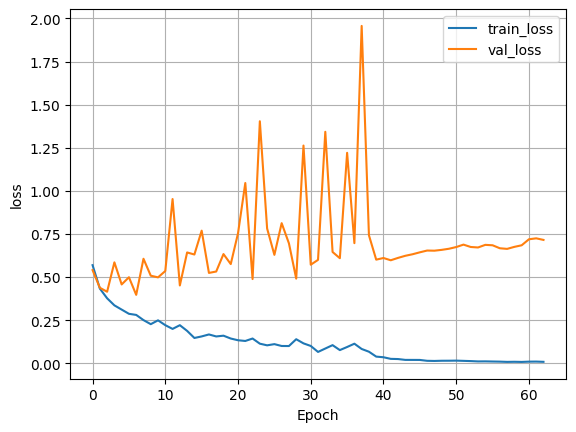

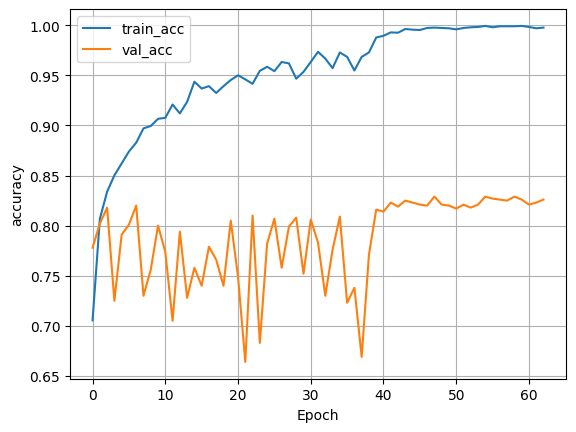

In [96]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\DepTag2\version_10\metrics.csv')

In [ ]:
# X1, y1 = next(iter(t_dataloader))
# X2, y2 = next(iter(v_dataloader))
# print(X1[0].x.device)
# print(X2[0].x.device)
# print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
# print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
# print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

In [ ]:
# import time
# def train_model(target_model, num_epoch = 2, target_device='cpu'):
#     target_model = target_model.to(target_device)
#     loss_func = torch.nn.BCEWithLogitsLoss()
#     optimizer = torch.optim.Adam(target_model.parameters(), 0.001, weight_decay=0.0055)
#     for i in range(num_epoch):
        
#         batch_acc=[]
#         batch_loss = []
#         begin = time.time()
#         target_model.train()
#         i = 0
#         for X,y in t_dataloader:
#             print(f'i: {i}')
#             i = i + 1
#             X = X.to(target_device)
#             y = y.to(target_device)
#             optimizer.zero_grad()
#             predicted = target_model(X)
#             loss = loss_func(predicted, y)
#             loss.backward()
#             optimizer.step()
#             predicted = torch.nn.functional.sigmoid(predicted)
#             predicted[predicted<0.5] = 0
#             predicted[predicted>=0.5] = 1
#             accuracy = torch.mean((predicted == y).to(torch.float32)).detach().item()
#             batch_acc.append(accuracy)
#             batch_loss.append(loss.item())
#             torch.cuda.empty_cache()
#         print(f'train accuracy: {np.mean(batch_acc)}, loss: {np.mean(batch_loss)}, duration: {time.time() - begin:0.4f}')
        
#         target_model.eval()
#         batch_acc=[]
#         batch_loss = []
#         i = 0
#         for X,y in v_dataloader:
#             print(f'i: {i}')
#             i = i + 1
#             X = X.to(target_device)
#             y = y.to(target_device)
#             with torch.inference_mode():
#                 predicted = target_model(X)
#                 loss = loss_func(predicted, y)
#             predicted = torch.nn.functional.sigmoid(predicted)
#             predicted[predicted<0.5] = 0
#             predicted[predicted>=0.5] = 1
#             accuracy = torch.mean((predicted == y).to(torch.float32)).detach().item()
#             batch_acc.append(accuracy)
#             batch_loss.append(loss.item())
#             torch.cuda.empty_cache()
#         print(f'validation accuracy: {np.mean(batch_acc)}, loss: {np.mean(batch_loss)}, duration: {time.time() - begin:0.4f}')

In [ ]:
# train_model(torch_model, 5, 'cpu')

In [ ]:
# train_model(torch_model, 5, 'cuda')